In [1]:
from tabulate import tabulate

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from mplfinance.original_flavor import candlestick_ohlc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from datetime import timedelta
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from math import ceil
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
close_price = pd.read_csv("data_updated/close.csv", index_col="Date")
high = pd.read_csv("data_updated/high.csv", index_col="Date")
low = pd.read_csv("data_updated/low.csv", index_col="Date")
volume = pd.read_csv("data_updated/volume.csv", index_col="Date")
open_price = pd.read_csv("data_updated/open.csv", index_col="Date")
adj_close = pd.read_csv("data_updated/adj_close.csv", index_col="Date")

In [4]:
crypto = pd.concat([open_price, close_price, high, low, volume, adj_close], axis=1, join="inner")

In [5]:
crypto

ADA-USD   ATOM-USD   AVAX-USD    AXS-USD       BTC-USD  \
Date                                                                  
2017-05-09       NaN        NaN        NaN        NaN   1723.890015   
2017-05-10       NaN        NaN        NaN        NaN   1756.520020   
2017-05-11       NaN        NaN        NaN        NaN   1780.369995   
2017-05-12       NaN        NaN        NaN        NaN   1845.760010   
2017-05-13       NaN        NaN        NaN        NaN   1723.119995   
...              ...        ...        ...        ...           ...   
2022-05-04  0.771107  17.593870  59.658340  29.114498  37748.011719   
2022-05-05  0.897061  19.871162  67.076157  33.362663  39695.746094   
2022-05-06  0.791065  17.853285  59.121109  28.982380  36573.183594   
2022-05-07  0.783352  17.676107  57.035454  28.464800  36042.503906   
2022-05-08  0.761689  16.511841  55.153175  28.747194  35473.250000   

                ETH-USD   LINK-USD  LUNA1-USD  MATIC-USD    SOL-USD  ...  \
Date                                                                 ...   
2017-05-09          NaN        NaN        NaN        NaN        NaN  ...   
2017-05-10          NaN        NaN        NaN        NaN        NaN  ...   
2017-05-11          NaN        NaN        NaN        NaN        NaN  ...   
2017-05-12          NaN        NaN        NaN        NaN        NaN  ...   
2017-05-13          NaN        NaN        NaN        NaN        NaN  ...   
...                 ...        ...        ...        ...        ...  ...   
2022-05-04  2783.131104  11.121224  82.584396   1.075928  85.841728  ...   
2022-05-05  2940.226562  12.153832  86.159637   1.170986  92.769791  ...   
2022-05-06  2748.931641  10.916577  82.551933   1.064479  84.588493  ...   
2022-05-07  2694.991943  10.799866  77.465630   1.044149  81.766670  ...   
2022-05-08  2637.407227  10.254740  68.271729   1.024481  79.022034  ...   

             ADA-USD   ATOM-USD   AVAX-USD    AXS-USD       BTC-USD  \
Date                                                                  
2017-05-09       NaN        NaN        NaN        NaN   1755.359985   
2017-05-10       NaN        NaN        NaN        NaN   1787.130005   
2017-05-11       NaN        NaN        NaN        NaN   1848.569946   
2017-05-12       NaN        NaN        NaN        NaN   1724.239990   
2017-05-13       NaN        NaN        NaN        NaN   1804.910034   
...              ...        ...        ...        ...           ...   
2022-05-04  0.896942  19.876862  67.086105  33.363853  39698.371094   
2022-05-05  0.791152  17.853285  59.127441  28.984409  36575.140625   
2022-05-06  0.783359  17.674110  57.034325  28.462557  36040.921875   
2022-05-07  0.761882  16.475998  55.156693  28.750196  35501.953125   
2022-05-08  0.744362  15.785578  51.730221  30.405958  34226.796875   

                ETH-USD   LINK-USD  LUNA1-USD  MATIC-USD    SOL-USD  
Date                                                                 
2017-05-09          NaN        NaN        NaN        NaN        NaN  
2017-05-10          NaN        NaN        NaN        NaN        NaN  
2017-05-11          NaN        NaN        NaN        NaN        NaN  
2017-05-12          NaN        NaN        NaN        NaN        NaN  
2017-05-13          NaN        NaN        NaN        NaN        NaN  
...                 ...        ...        ...        ...        ...  
2022-05-04  2940.644775  12.145610  86.172264   1.171032  92.770851  
2022-05-05  2749.213135  10.917400  82.580406   1.064691  84.596024  
2022-05-06  2694.979736  10.799844  77.464806   1.044133  81.764107  
2022-05-07  2636.093018  10.239905  68.249123   1.021204  78.983421  
2022-05-08  2532.283691  10.044308  64.176682   0.979784  75.536499  

[1826 rows x 60 columns]

In [6]:
ada_usd = crypto["ADA-USD"]
atom_usd = crypto["ATOM-USD"]
avax_usd = crypto["AVAX-USD"]
axs_usd = crypto["AXS-USD"]
btc_usd = crypto["BTC-USD"]
eth_usd = crypto["ETH-USD"]
luna_usd = crypto["LUNA1-USD"]
matic_usd = crypto["MATIC-USD"]
sol_usd = crypto["SOL-USD"]
link_usd= crypto["LINK-USD"]

In [7]:
all_pairs = ['ADA-USD', 'ATOM-USD', 'AVAX-USD', 'AXS-USD', 'LUNA-USD', 'MATIC-USD', 'BTC-USD', 'ETH-USD', 'SOL-USD', "LINK-USD"]
close_price["LUNA-USD"] = close_price["LUNA1-USD"]
close_price.drop("LUNA1-USD", axis=1, inplace=True)

In [8]:
close_price

ADA-USD   ATOM-USD   AVAX-USD    AXS-USD       BTC-USD  \
Date                                                                  
2017-05-09       NaN        NaN        NaN        NaN   1755.359985   
2017-05-10       NaN        NaN        NaN        NaN   1787.130005   
2017-05-11       NaN        NaN        NaN        NaN   1848.569946   
2017-05-12       NaN        NaN        NaN        NaN   1724.239990   
2017-05-13       NaN        NaN        NaN        NaN   1804.910034   
...              ...        ...        ...        ...           ...   
2022-05-04  0.896942  19.876862  67.086105  33.363853  39698.371094   
2022-05-05  0.791152  17.853285  59.127441  28.984409  36575.140625   
2022-05-06  0.783359  17.674110  57.034325  28.462557  36040.921875   
2022-05-07  0.761882  16.475998  55.156693  28.750196  35501.953125   
2022-05-08  0.744362  15.785578  51.730221  30.405958  34226.796875   

                ETH-USD   LINK-USD  MATIC-USD    SOL-USD   LUNA-USD  
Date                                                                 
2017-05-09          NaN        NaN        NaN        NaN        NaN  
2017-05-10          NaN        NaN        NaN        NaN        NaN  
2017-05-11          NaN        NaN        NaN        NaN        NaN  
2017-05-12          NaN        NaN        NaN        NaN        NaN  
2017-05-13          NaN        NaN        NaN        NaN        NaN  
...                 ...        ...        ...        ...        ...  
2022-05-04  2940.644775  12.145610   1.171032  92.770851  86.172264  
2022-05-05  2749.213135  10.917400   1.064691  84.596024  82.580406  
2022-05-06  2694.979736  10.799844   1.044133  81.764107  77.464806  
2022-05-07  2636.093018  10.239905   1.021204  78.983421  68.249123  
2022-05-08  2532.283691  10.044308   0.979784  75.536499  64.176682  

[1826 rows x 10 columns]

In [9]:
ada_usd.columns.values[0] = "Open Price"
ada_usd.columns.values[1] = "Close Price"
ada_usd.columns.values[2] = "Daily High"
ada_usd.columns.values[3] = "Daily Low"
ada_usd.columns.values[4] = "Volume"
ada_usd.columns.values[5] = "Adj Close"

atom_usd.columns.values[0] = "Open Price"
atom_usd.columns.values[1] = "Close Price"
atom_usd.columns.values[2] = "Daily High"
atom_usd.columns.values[3] = "Daily Low"
atom_usd.columns.values[4] = "Volume"
atom_usd.columns.values[5] = "Adj Close"

avax_usd.columns.values[0] = "Open Price"
avax_usd.columns.values[1] = "Close Price"
avax_usd.columns.values[2] = "Daily High"
avax_usd.columns.values[3] = "Daily Low"
avax_usd.columns.values[4] = "Volume"
avax_usd.columns.values[5] = "Adj Close"

axs_usd.columns.values[0] = "Open Price"
axs_usd.columns.values[1] = "Close Price"
axs_usd.columns.values[2] = "Daily High"
axs_usd.columns.values[3] = "Daily Low"
axs_usd.columns.values[4] = "Volume"
axs_usd.columns.values[5] = "Adj Close"

btc_usd.columns.values[0] = "Open Price"
btc_usd.columns.values[1] = "Close Price"
btc_usd.columns.values[2] = "Daily High"
btc_usd.columns.values[3] = "Daily Low"
btc_usd.columns.values[4] = "Volume"
btc_usd.columns.values[5] = "Adj Close"

eth_usd.columns.values[0] = "Open Price"
eth_usd.columns.values[1] = "Close Price"
eth_usd.columns.values[2] = "Daily High"
eth_usd.columns.values[3] = "Daily Low"
eth_usd.columns.values[4] = "Volume"
eth_usd.columns.values[5] = "Adj Close"

luna_usd.columns.values[0] = "Open Price"
luna_usd.columns.values[1] = "Close Price"
luna_usd.columns.values[2] = "Daily High"
luna_usd.columns.values[3] = "Daily Low"
luna_usd.columns.values[4] = "Volume"
luna_usd.columns.values[5] = "Adj Close"

link_usd.columns.values[0] = "Open Price"
link_usd.columns.values[1] = "Close Price"
link_usd.columns.values[2] = "Daily High"
link_usd.columns.values[3] = "Daily Low"
link_usd.columns.values[4] = "Volume"
link_usd.columns.values[5] = "Adj Close"

matic_usd.columns.values[0] = "Open Price"
matic_usd.columns.values[1] = "Close Price"
matic_usd.columns.values[2] = "Daily High"
matic_usd.columns.values[3] = "Daily Low"
matic_usd.columns.values[4] = "Volume"
matic_usd.columns.values[5] = "Adj Close"

sol_usd.columns.values[0] = "Open Price"
sol_usd.columns.values[1] = "Close Price"
sol_usd.columns.values[2] = "Daily High"
sol_usd.columns.values[3] = "Daily Low"
sol_usd.columns.values[4] = "Volume"
sol_usd.columns.values[5] = "Adj Close"

In [10]:
df = btc_usd.copy()
coin_name = "Bitcoin"

#bollinger window parameters
boll_window = 30
df['sma30'] = df['Close Price'].rolling(boll_window).mean()
df['std'] = df['Close Price'].rolling(boll_window).std(ddof = 0)
df.reset_index(inplace=True)

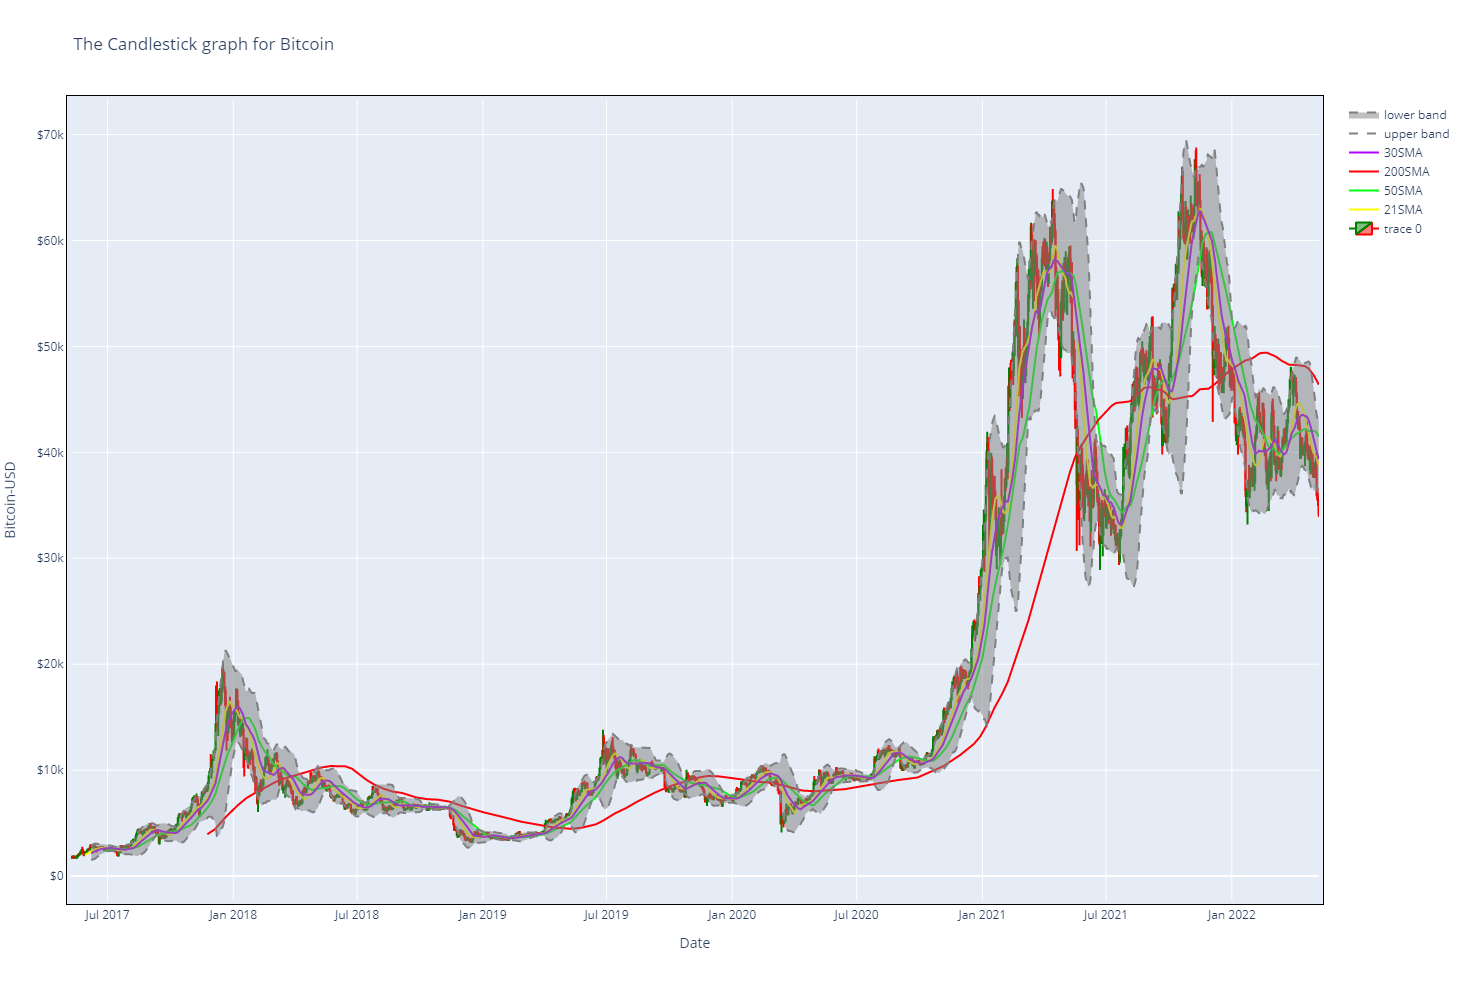

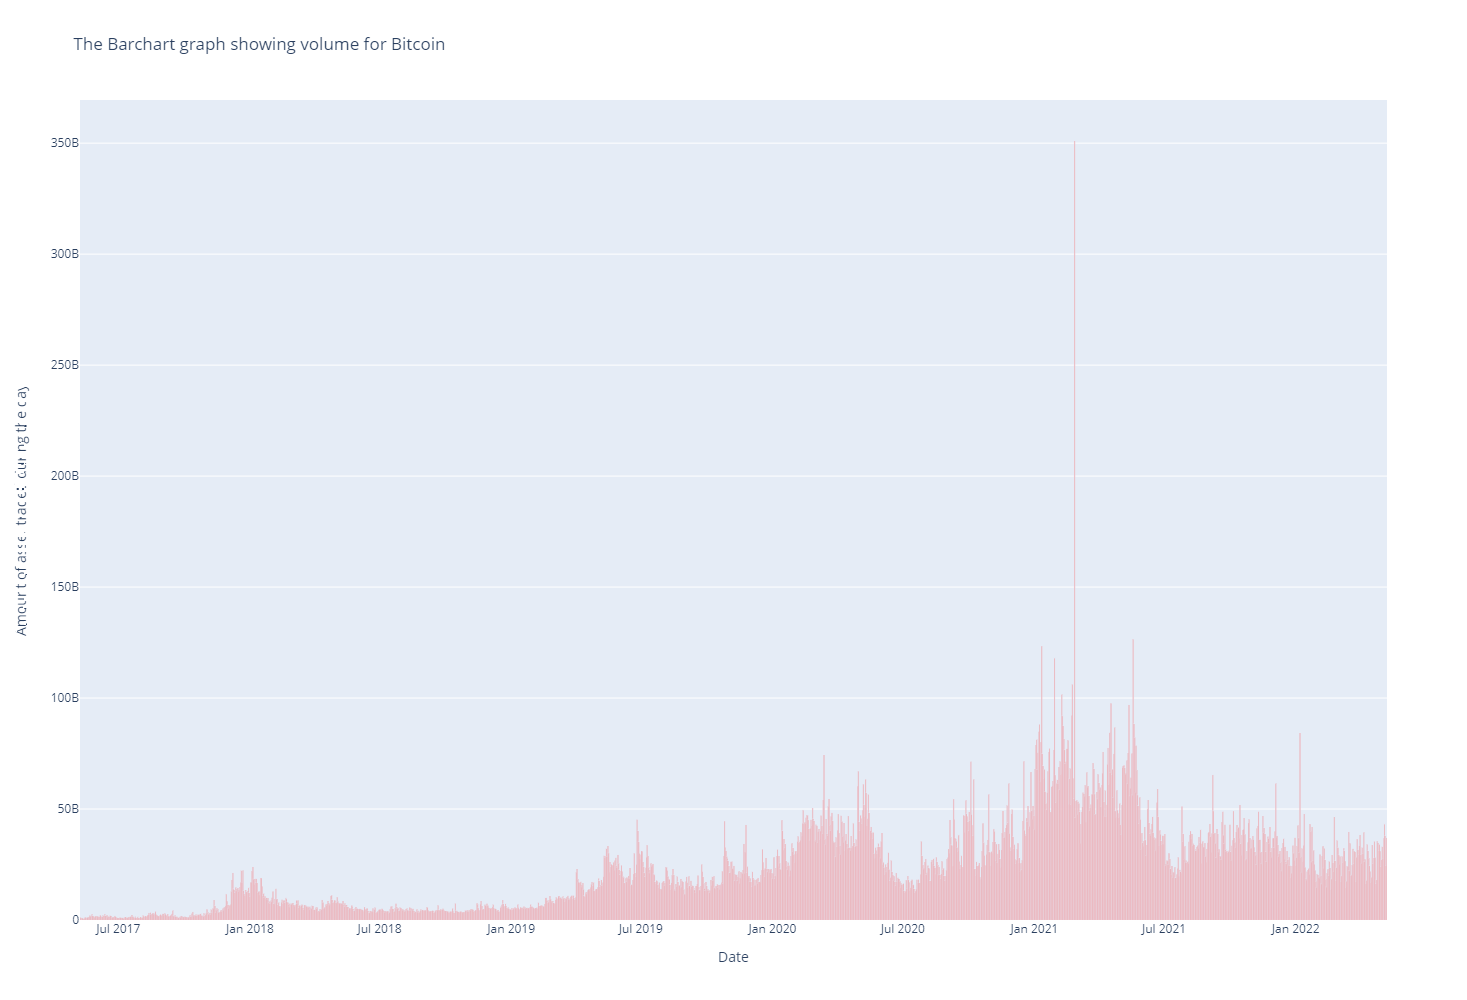

In [11]:
# IMPORTANT NOTE: We can adapt this similar plot for each type of currency 



fig = make_subplots(rows = 1, cols = 1)

layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
), #
            go.Scatter(
                x = df['Date'], 
                y = df["Close Price"].rolling(window=21).mean(),
                mode = 'lines', 
                name = '21SMA',
                line = {'color': '#ffff00'}
            ),
            go.Scatter(
                x = df['Date'], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines',
                name = '50SMA',
                line = {'color': '#00ff11'}
            ), 
            go.Scatter(
                x = df['Date'], 
                y = df["Close Price"].rolling(window=200).mean(),
                mode = 'lines', 
                name = '200SMA',
                line = {'color': '#ff0008'}
            ), 
            go.Scatter(
                x = df['Date'], 
                y = df["sma30"],
                mode = 'lines', 
                name = '30SMA',
                line = {'color': '#b300ff'}
            ),
             go.Scatter(
                x = df['Date'], 
                y = df['sma30'] + (df['std'] * 2),
                line_color = 'gray',
                line = {'dash': 'dash'},
                name = 'upper band',
                opacity = 0.5
            ),
            go.Scatter(
                x = df['Date'], 
                y = df['sma30'] - (df['std'] * 2),
                line_color = 'gray',
                line = {'dash': 'dash'},
                fill = 'tonexty',
                name = 'lower band',
                opacity = 0.5
            ),
        ]
    ,layout=layout)

fig2 = go.Figure(
            data = go.Bar(
                x = df['Date'],
                y = df["Volume"],
                marker_color = "red"
            )
)
fig.update_layout(
    title = f'The Candlestick graph for {coin_name}',
    xaxis_title = 'Date',
    yaxis_title = f'{coin_name}-USD',
    xaxis_rangeslider_visible = False #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')

fig2.update_layout(
    title = f'The Barchart graph showing volume for {coin_name}',
    xaxis_title = 'Date',
    yaxis_title = 'Amount of asset traded during the day',
    xaxis_rangeslider_visible = False, #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
    autosize=False,
    width=1000,
    height=1000,
)

fig.show()
fig2.show()

In [12]:
df.tail(5)

Date    Open Price   Close Price    Daily High     Daily Low  \
1821  2022-05-04  37748.011719  39698.371094  39902.949219  37732.058594   
1822  2022-05-05  39695.746094  36575.140625  39789.281250  35856.515625   
1823  2022-05-06  36573.183594  36040.921875  36624.359375  35482.132812   
1824  2022-05-07  36042.503906  35501.953125  36129.925781  34940.824219   
1825  2022-05-08  35473.250000  34226.796875  35477.484375  33913.957031   

           Volume     Adj Close         sma30          std  
1821  36754404490  39698.371094  40409.333333  1782.701436  
1822  43106256317  36575.140625  40109.971615  1641.799272  
1823  37795577489  36040.921875  39871.111068  1694.311234  
1824  24375896406  35501.953125  39604.381250  1730.887430  
1825  36945944576  34226.796875  39335.685677  1909.900753

In [19]:
def GetTradingStrategy(df, short_window = 20, long_window = 50, indicator = 'SMA'):
    '''
    The function takes the cyptocurrency, look-back periods and the indicator type(SMA or EMA) as input 
    and returns the respective MA Crossover chart along with the buy/sell signals for the given period.
    '''
    # short_window - (int)lookback period for short-term moving average. Eg: 5, 10, 20 
    # long_window - (int)lookback period for long-term moving average. Eg: 50, 100, 200
    # moving_avg - (str)the type of moving average to use ('SMA' or 'EMA')
    # display_table - (bool)whether to display the date and price table at buy/sell positions(True/False)
    
    
  # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + indicator
    long_window_col = str(long_window) + '_' + indicator 
    
    if indicator == 'SMA':
        # Create a short simple moving average column
        df[short_window_col] = df['Close Price'].rolling(window = short_window, min_periods = 1).mean()

        # Create a long simple moving average column
        df[long_window_col] = df['Close Price'].rolling(window = long_window, min_periods = 1).mean()

    elif indicator == 'EMA':
        # Create short exponential moving average column
        df[short_window_col] = df['Close Price'].ewm(span = short_window, adjust = False).mean()

        # Create a long exponential moving average column
        df[long_window_col] = df['Close Price'].ewm(span = long_window, adjust = False).mean()

    # create a new column 'Signal' such that if faster moving average is greater than slower moving average 
    # then set Signal as 1 else 0.
    df['Signal'] = 0.0  
    df['Signal'] = np.where(df[short_window_col] > df[long_window_col], 1.0, 0.0) 

    # create a new column 'Position' which is a day-to-day difference of the 'Signal' column. 
    df['Position'] = df['Signal'].diff() 


    fig = make_subplots(rows = 1, cols = 1)
    
    layout = go.Layout(
        autosize=False,
        width=1000,
        height=1000,
        
    
        xaxis= go.layout.XAxis(linecolor = 'black',
                              linewidth = 1,
                              mirror = True),
    
        yaxis= go.layout.YAxis(linecolor = 'black',
                              linewidth = 1,
                              mirror = True),
    
        margin=go.layout.Margin(
            l=50,
            r=50,
            b=100,
            t=100,
            pad = 4
        )
    )
    
    fig = go.Figure(
    
        data=[go.Candlestick(
        x=df['Date'],
        open=df['Open Price'], high=df['Daily High'],
        low=df['Daily Low'], close=df['Close Price'],
        increasing_line_color= 'Green', decreasing_line_color= 'Red'
    ), #
                go.Scatter(
                    x = df['Date'], 
                    y = df[short_window_col],
                    mode = 'lines', 
                    name = short_window_col,
                    line = {'color': '#00ff11'}
                ),
                go.Scatter(
                    x = df['Date'], 
                    y = df[long_window_col],
                    mode = 'lines',
                    name = long_window_col,
                    line = {'color': '#ff0008'}
                ),
                go.Scatter(
                    x = df["Date"][df["Position"] == -1], 
                    y = df[long_window_col][df["Position"] == -1],
                    mode = 'markers',
                    marker= dict(symbol='triangle-down', size = 14),
                    name = 'Sell',
                    line = {'color': '#ff0000'}
                ),
                go.Scatter(
                    x = df["Date"][df["Position"] == 1], 
                    y = df[short_window_col][df["Position"] == 1],
                    mode = 'markers',
                    marker= dict(symbol='triangle-up', size = 14),
                    name = 'Buy',
                    line = {'color': '#00ff95'}
                ), 
                
                 go.Scatter(
                    x = df['Date'], 
                    y = df['sma30'] + (df['std'] * 2),
                    line_color = 'gray',
                    line = {'dash': 'dash'},
                    name = 'upper band',
                    opacity = 0.5
                ),
                go.Scatter(
                    x = df['Date'], 
                    y = df['sma30'] - (df['std'] * 2),
                    line_color = 'gray',
                    line = {'dash': 'dash'},
                    fill = 'tonexty',
                    name = 'lower band',
                    opacity = 0.5
                ),
              
            ]
        ,layout=layout)
    
   # for i in range (len(df_levels)):
        #fig.add_trace(go.Scatter(x = df_levels["Date"], y = df_levels["Price_level"], mode ='lines', name = col))
        #fig.add_hline(y=df_levels["Price_level"].iloc[:-1], row=all, line_width=2, line_dash="dash", line_color="green")
            
    
    #fig.add_hline(y=400, row=all, line_width=2, line_dash="dash", line_color="green")
    fig.update_layout(
        title = f'The Candlestick graph for {coin_name}',
        xaxis_title = 'Date',
        yaxis_title = f'{coin_name}-USD',
        xaxis_rangeslider_visible = False #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
    )
    
    fig.show()

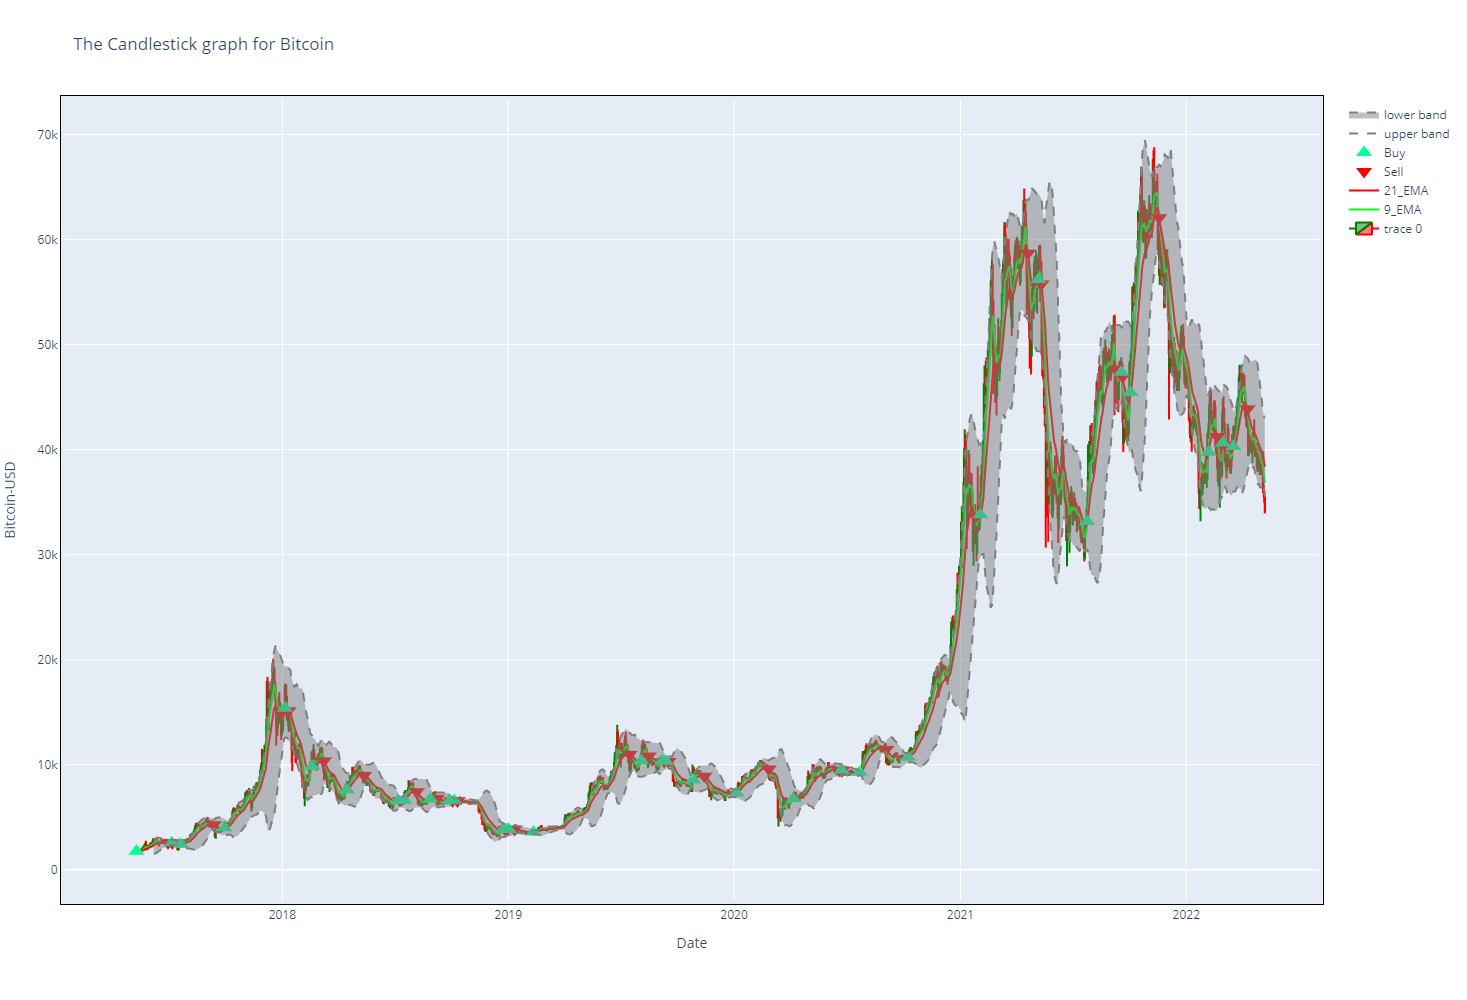

In [23]:
GetTradingStrategy(df, 9, 21,'EMA')

In [24]:
#method 1: fractal candlestick pattern
# determine bullish fractal 
def is_support(df,i):  
    cond1 = df['Daily Low'][i] < df['Daily Low'][i-1]   
    cond2 = df['Daily Low'][i] < df['Daily Low'][i+1]   
    cond3 = df['Daily Low'][i+1] < df['Daily Low'][i+2]   
    cond4 = df['Daily Low'][i-1] < df['Daily Low'][i-2]  
    return (cond1 and cond2 and cond3 and cond4) 
# determine bearish fractal
def is_resistance(df,i):  
    cond1 = df['Daily High'][i] > df['Daily High'][i-1]   
    cond2 = df['Daily High'][i] > df['Daily High'][i+1]   
    cond3 = df['Daily High'][i+1] > df['Daily High'][i+2]   
    cond4 = df['Daily High'][i-1] > df['Daily High'][i-2]  
    return (cond1 and cond2 and cond3 and cond4)
# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df):    
    ave =  np.mean(df['Daily High'] - df['Daily Low'])    
    return np.sum([abs(value-level)<ave for _,level in levels])==0

# a list to store resistance and support levels
levels = []
for i in range(2, df.shape[0] - 2):  
    if is_support(df, i):    
        low = df['Daily Low'][i]    
        if is_far_from_level(low, levels, df):      
            levels.append((df["Date"][i], low))  
    elif is_resistance(df, i):    
        high = df['Daily High'][i]    
        if is_far_from_level(high, levels, df):      
            levels.append((df["Date"][i], high))

In [200]:
df_levels = pd.DataFrame(levels, columns=["Date", "Price_level"])

In [174]:
levels[1]

('2017-05-25', 2763.7099609375)

In [199]:
len(df_levels)

38

In [144]:
df_levels.set_index("Date", inplace=True)

In [146]:
df_levels["Price_level"]

Date
2017-05-17     1661.910034
2017-05-25     2763.709961
2017-09-02     4975.040039
2017-10-21     6194.879883
2017-11-05     7617.479980
2017-11-30     9202.049805
2017-12-08    18353.400391
2017-12-10    13226.599609
2017-12-17    20089.000000
2017-12-27    16930.900391
2018-01-25    11785.700195
2019-03-12     3863.559082
2020-10-02    10416.689453
2020-11-06    15903.437500
2020-12-20    24209.660156
2020-12-27    28288.839844
2021-01-08    41946.738281
2021-01-14    39966.406250
2021-01-19    37755.890625
2021-01-27    29367.138672
2021-02-21    58330.570312
2021-03-03    52535.136719
2021-03-05    46542.515625
2021-03-25    50856.570312
2021-04-07    55604.023438
2021-04-14    64863.097656
2021-05-30    33520.738281
2021-06-08    31114.443359
2021-06-29    36542.109375
2021-07-12    34592.156250
2021-08-19    43998.316406
2021-08-29    49644.113281
2021-10-15    62757.128906
2021-10-20    66930.390625
2021-11-01    59695.183594
2021-11-10    68789.625000
2022-03-02    45077.578

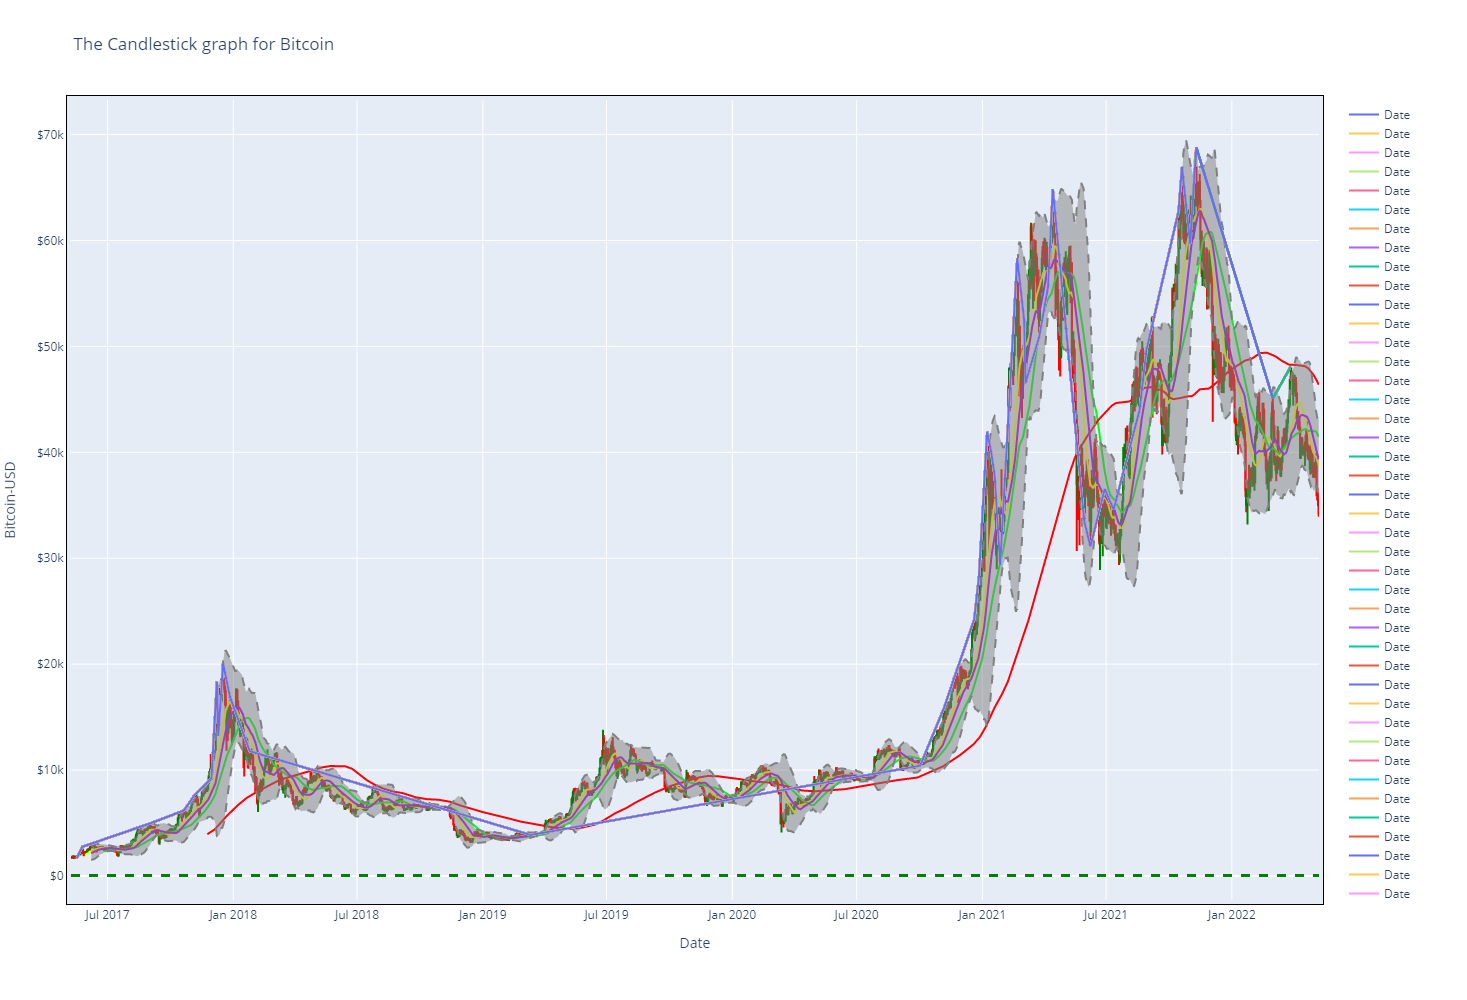

In [185]:
fig.show()

In [203]:
print(len(levels))

38


EMA [today] = (α x Price [today] ) + ((1 — α) x EMA [yesterday] )

Where:
α = 2/(N + 1)
N = the length of the window (moving average period)
EMA [today] = the current EMA value
Price [today] = the current closing price
EMA [yesterday] = the previous EMA value

CODE TO IMPLEMENT RESISTANCE SUPPORT FROM MATPLOTLIB

def plot_all(levels, df):    
    fig, ax = plt.subplots(figsize=(16, 9))   
    candlestick_ohlc(ax,df.values,width=0.6, colorup='green', 
        colordown='red', alpha=0.8)    
    date_format = mpl_dates.DateFormatter('%d %b %Y')
    ax.xaxis.set_major_formatter(date_format)    
    for level in levels:        
        plt.hlines(level[1], xmin = df['Date'][level[0]], xmax = 
            max(df['Date']), colors='blue', linestyle='--')    
    fig.show()